# Attention Model

Compute attention mask post-hoc and sum up the vectors.

### Hyperparameters

In [64]:
max_textlen = 3
word_dim, vocab_size = 5, 10
hidden_dim, filter_len = 16, 1

nb_class = 2

Define a layer which sums along `axis=0`...

In [65]:
import keras.backend as K

def sum_vectors(x):
    """Sums a batch of vectors
    
    Parameters
    ----------
    x : (nb_batch, max_textlen, nb_filter) tensor
    
    Sums `x` along `axis=1` and returns a (nb_batch, nb_filter) tensor.
    
    """
    return K.sum(x, axis=1)

### Define Model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 3)             0                                            
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 3, 5)          50          input_6[0][0]                    
____________________________________________________________________________________________________
activations (LSTM)               (None, 3, 16)         1408        embedding_6[0][0]                
____________________________________________________________________________________________________
timedistributed_6 (TimeDistribute(None, 3, 1)          17          activations[0][0]                
___________________________________________________________________________________________

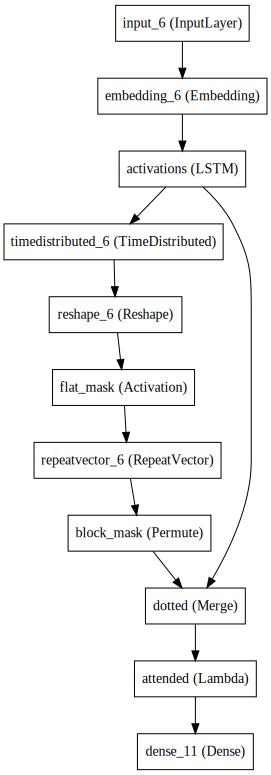

In [66]:
from keras.layers import Input, Embedding, Dense, LSTM, merge, Activation, Permute, Reshape, Lambda
from keras.layers import Convolution1D, MaxPooling1D, Flatten, TimeDistributed, RepeatVector
from keras.layers.convolutional import AveragePooling1D
from keras.models import Model

input = Input(shape=[max_textlen], dtype='int32')
embedded = Embedding(output_dim=word_dim, input_dim=vocab_size, input_length=max_textlen)(input)
activations = LSTM(hidden_dim, return_sequences=True, name='activations')(embedded)

# attention mask
mask = TimeDistributed(Dense(1))(activations)
mask = Reshape([max_textlen])(mask)
mask = Activation('softmax', name='flat_mask')(mask)
mask = RepeatVector(16)(mask)
mask = Permute([2, 1], name='block_mask')(mask)

# apply mask
activations = merge([activations, mask], mode='mul', name='dotted')
collapsed = Lambda(function=sum_vectors, output_shape=[hidden_dim], name='attended')(activations)

probas = Dense(nb_class, activation='softmax')(collapsed)

model = Model(input=input, output=probas)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train Model

In [67]:
from keras.utils.np_utils import to_categorical

X, y = np.array([[1, 2, 4], [0, 3, 4]]), to_categorical([1, 0])

model.fit(X, y)

Epoch 1/10
2/2 [==============================] - 0s - loss: 0.6909 - acc: 0.5000
Epoch 2/10
2/2 [==============================] - 0s - loss: 0.6903 - acc: 1.0000
Epoch 3/10
2/2 [==============================] - 0s - loss: 0.6897 - acc: 1.0000
Epoch 4/10
2/2 [==============================] - 0s - loss: 0.6891 - acc: 1.0000
Epoch 5/10
2/2 [==============================] - 0s - loss: 0.6885 - acc: 1.0000
Epoch 6/10
2/2 [==============================] - 0s - loss: 0.6879 - acc: 1.0000
Epoch 7/10
2/2 [==============================] - 0s - loss: 0.6872 - acc: 1.0000
Epoch 8/10
2/2 [==============================] - 0s - loss: 0.6865 - acc: 1.0000
Epoch 9/10
2/2 [==============================] - 0s - loss: 0.6859 - acc: 1.0000
Epoch 10/10
2/2 [==============================] - 0s - loss: 0.6851 - acc: 1.0000


### Test Layers

In [68]:
layer_names = ['activations', 'flat_mask', 'block_mask', 'dotted', 'attended']
outputs = [model.get_layer(layer_name).output for layer_name in layer_names]

f = K.function(model.inputs, outputs)

activations, flat_mask, block_mask, dotted, attended = [output[0] for output in f([X[:1]])]

assert np.all(activations * block_mask == dotted)

dotted.sum(axis=0) == attended

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False], dtype=bool)

In [69]:
dotted.sum(axis=0)

array([-0.00892711,  0.00826923, -0.01406729, -0.00389274,  0.00661503,
        0.00420704, -0.0016395 , -0.00740139, -0.00675155, -0.00387378,
       -0.00329243, -0.00311931,  0.0014338 , -0.00325761,  0.01508329,
       -0.00647725], dtype=float32)

In [70]:
attended

array([-0.00892711,  0.00826923, -0.01406729, -0.00389274,  0.00661503,
        0.00420704, -0.0016395 , -0.00740139, -0.00675155, -0.00387378,
       -0.00329243, -0.00311931,  0.0014338 , -0.00325761,  0.01508329,
       -0.00647725], dtype=float32)

Looks like it works with the exception of some theano/numpy precision difference...